# Deep Reinforcement Learning for Robotic Systems 

## Synopsis

This notebook outlines the modelling and integration of the [Proximal Policy Optimisation](http://arxiv.org/abs/1707.06347) algorithm on an **inverted double pendulum** as a baseline study into advanced astrodynamical control systems, such as docking and berthing of spacecraft, and rocket initialisation stabilisation. 

#### *Note*: Please view this workbook [here](https://nbviewer.jupyter.org/github/mughees-asif/dip/blob/master/deep-learning-dip.ipynb), as GitHub has an ongoing problem rendering Jupyter Notebooks.  

--------

Produced by *[Mughees Asif](https://github.com/mughees-asif)*, under supervision of [Dr. Angadh Nanjangud](https://www.sems.qmul.ac.uk/staff/a.nanjangud) (Lecturer in Aerospace/Spacecraft Engineering @ [Queen Mary, University of London](https://www.sems.qmul.ac.uk/)).



## 1. Overview

Proximal Policy Optimisation is a deep reinforcement learning algorithm developed by [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html). It has proven to be successful in a variety of tasks ranging from enabling robotic systems in complex environments, to developing proficiency in computer gaming by using stochastic mathematical modelling to simulate real-life decision making. For the purposes of this research, the algorithm will be implemented to vertically stablise an inverted double pendulum, which is widely used in industry as a benchmark to validate the veracity of next-generation intelligent algorithms.

## 2. Model description

An inverted double pendulum is a characteristic example of a simple-to-build, non-linear, and chaotic mechanical system that has been widely studied in the fields of Robotics, Aerospace, Biomedical, Mechanical Engineering, and Mathematical Analysis.

<img src="images/dip_fbd.png" width="350" />

## 3. Variables

<img src="images/variables.png" width="400" />

## 4. Governing equations of motion

The following section utilises the [SymPy](https://www.sympy.org/en/index.html) package to derive the governing equations of motion. 

### 4.1. Basic modelling

<img src="images/dip_fbd_radius.png" width="300" />

In [47]:
import sympy

# initiliase variables
t = sympy.symbols('t')        # time
m = sympy.symbols('m')        # mass of the cart
l = sympy.symbols('l')        # length of the pendulums, l_1 = l_2 = l
M = sympy.symbols('M')        # mass of the pendulums, M_1 = M_2 = M
I = sympy.symbols('I')        # moment of inertia
g = sympy.symbols('g')        # gravitational constant, 9.81 m/s^2
F = sympy.symbols('F')        # force applied to the cart

x = sympy.Function('x')(t)    # |
Θ = sympy.Function('Θ')(t)    # | --- functions of (t)
Φ = sympy.Function('Φ')(t)    # |

# cart
x_dot = x.diff(t)             # velocity

# pendulum(s) 
x_1 = x + (l*sympy.sin(Θ))    # | --- position
x_2 = l*sympy.cos(Θ)          # | 

v_1 = x_1 + l*sympy.sin(Φ)                                             # |
v_2 = x_2 + l*sympy.cos(Φ)                                             # | --- linear velocity
v_3 = sympy.sqrt(sympy.simplify(x_1.diff(t)**2 + x_2.diff(t)**2))      # |  
v_4 = sympy.sqrt(sympy.simplify(v_1.diff(t)**2 + v_2.diff(t)**2))      # |

Θ_dot = Θ.diff(t)             # | --- angular velocity
Φ_dot = Φ.diff(t)             # |

### 4.2. Kinetic and Potential Energy

In [48]:
# kinetic energy 
K = 0.5*((m*x_dot**2) + M*(v_3**2 + v_4**2) + I*(Θ_dot**2 + Φ_dot**2))

# potential energy 
P = M*g*l*(2*sympy.cos(Θ) + sympy.cos(Φ))

------------------------------
The kinetic energy, K, of the system: 
------------------------------


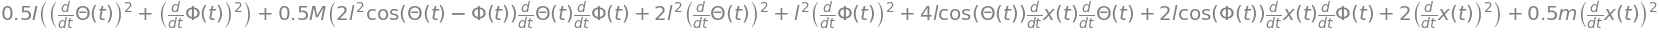

In [85]:
print('------------------------------')
print('The kinetic energy, K, of the system: \n------------------------------')
K

In [86]:
print('------------------------------')
print('The potential energy, P, of the system:\n------------------------------')
P

------------------------------
The potential energy, P, of the system:
------------------------------


### 4.3. The Lagrangian

The action $S$ of the cart (movement; left, right) is mathematically defined as:

$$S = \int_{t_{0}}^{t_{1}} K - P \,dt$$

but, $L = K - P$

$$\therefore S = \int_{t_{0}}^{t_{1}} L \,dt$$

------------------------------
The Lagrangian of the system is:
------------------------------


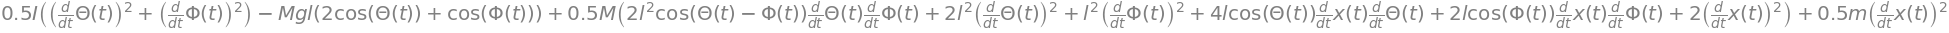

In [84]:
# the lagrangian
L = K - P

print('------------------------------')
print('The Lagrangian of the system is:\n------------------------------')
L

### 4.4. The Euler-Lagrange equations

The standard [Euler-Lagrange equation](https://www.ucl.ac.uk/~ucahmto/latex_html/chapter2_latex2html/node5.html) is:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = 0$$

To introduce the generalised force acting on the cart, the [Lagrange-D'Alembert Principle](https://en.wikipedia.org/wiki/D%27Alembert%27s_principle) is used:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = Q^{P}$$

Therefore, for a three-dimensional _working_ system, the equations of motion can be derived as:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = F - \dot x$$
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0$$
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{\phi}} - \frac{\partial L}{\partial \phi} = 0$$

------------------------------
The Euler-Lagrange equations:
------------------------------
1.


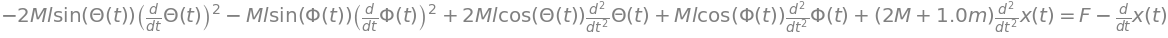

In [83]:
# euler-lagrange formulation
euler_1 = sympy.Eq((L.diff(x_dot).diff(t) - L.diff(x)).simplify().expand().collect(x.diff(t, t)), F - x.diff(t))
euler_2 = sympy.Eq((L.diff(Θ_dot).diff(t) - L.diff(Θ)).simplify().expand().collect(Θ.diff(t, t)), 0)
euler_3 = sympy.Eq((L.diff(Φ_dot).diff(t) - L.diff(Φ)).simplify().expand().collect(Φ.diff(t, t)), 0)

print('------------------------------')
print('The Euler-Lagrange equations:\n------------------------------\n1.')
euler_1

2.


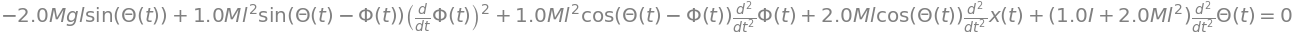

In [53]:
print('2.')
euler_2

3.


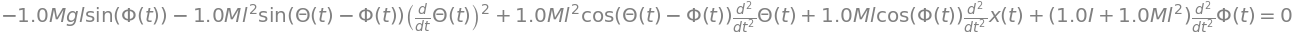

In [54]:
print('3.')
euler_3

### 4.5. Linearisation and acceleration

[Hartman-Grobman theorem](https://en.wikipedia.org/wiki/Hartman%E2%80%93Grobman_theorem)

The pendulum will achieve equilibrium when vertical, i.e. $\theta=0$ & $\phi=0$:

$$\sin(\theta)=\theta, \quad \cos(\theta)=1, \quad \dot\theta^{2}=0$$

$$\sin(\phi)=\phi, \quad \cos(\phi)=1, \quad \dot\phi^{2}=0$$

$$\sin(\theta - \phi)=\theta - \phi, \quad\quad \cos(\theta - \phi)=1$$

------------------------------
The linear equations are: 
------------------------------
1.


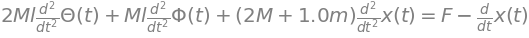

In [82]:
# linearise the system
matrix = [(sympy.sin(Θ), Θ), (sympy.cos(Θ), 1), (Θ_dot**2, 0), 
         (sympy.sin(Φ), Φ), (sympy.cos(Φ), 1), (Φ_dot**2, 0),
         (sympy.sin(Θ - Φ), Θ - Φ), (sympy.cos(Θ - Φ), 1)]

linear_1 = euler_1.subs(matrix)
linear_2 = euler_2.subs(matrix)
linear_3 = euler_3.subs(matrix)

print('------------------------------')
print('The linear equations are: \n------------------------------\n1.')
linear_1

2. 


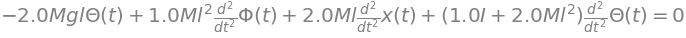

In [56]:
print('2. ')
linear_2

3. 


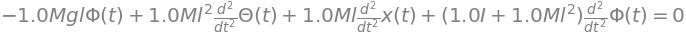

In [57]:
print('3. ')
linear_3

------------------------------
x_acceleration:
------------------------------


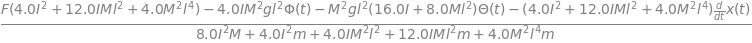

In [87]:
# simplify for linear and angular acceleration
final_equations = sympy.linsolve([linear_1, linear_2, linear_3], [x.diff(t, t), Θ.diff(t, t), Φ.diff(t, t)])

x_ddot = final_equations.args[0][0].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()
Θ_ddot = final_equations.args[0][1].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()
Φ_ddot = final_equations.args[0][2].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()

print('------------------------------')
print('x_acceleration:\n------------------------------')
x_ddot      

------------------------------
Θ_acceleration:
------------------------------


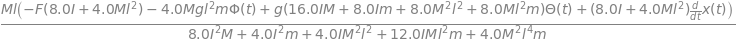

In [89]:
print('------------------------------')
print('Θ_acceleration:\n------------------------------')
Θ_ddot

------------------------------
Φ_acceleration:
------------------------------


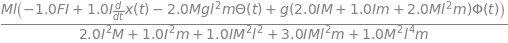

In [88]:
print('------------------------------')
print('Φ_acceleration:\n------------------------------')
Φ_ddot         

## 5. Proximal Policy Optimisation